**Introduction to Deep Learning**

- this code using Tensorflow: https://www.tensorflow.org/ (a Google python library for deep learning)

This lab is adapted for CSC4007 from the Chapter 10 lab notebook from "Hands-on Machine Learning with Scikit-Learn & Tensorflow".

I have shortened it somewhat for teaching purposes; you may want to look also as the orignal notebook, on github.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images",  fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Activation functions

Let's plot some activation functions that are commonly used in neural network machine learning. We have already seen in lectures the heaviside/threshold function, and the sigmoid function.

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    # to calculate a derivative with respect to z, we just need to see how the function changes near the value z.
    return (f(z + eps) - f(z - eps))/(2 * eps)

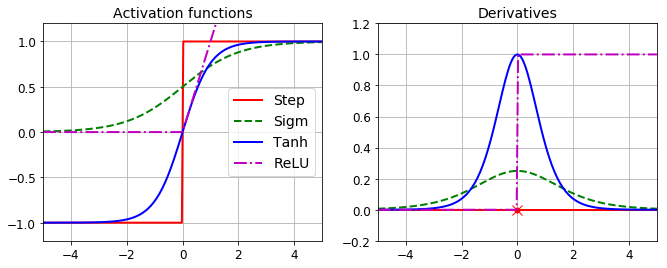

In [5]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=2, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigm")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigm")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

#save_fig("activation_functions_plot")
plt.show()

The ReLU activation function is a relatively recently developed activation function choice in machine learning. It tends to work well with deep neural networks (i.e. networks with many hidden layers between input and output), and has an easy to calculate derivative. 

# FNN for MNIST

We will now train a neural network model on the MNIST dataset. 

The MNIST dataset is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau.

Each image is labelled with the image it represents.

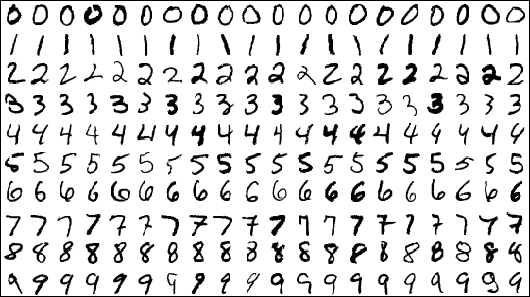

We have already seen this dataset -- and a similar network -- in the 3Blue1Brown videos.

MNIST is commonly used in the development and evaluation of machine learning algorithms.

In [6]:
import tensorflow
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [7]:
X_train = mnist.train.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_test = mnist.test.labels.astype("int")

OK, lets take a look at the data:

In [8]:
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("y_test first values: {}".format(y_test[:20]))
first_image = X_test[0]
print("X_test first item shape: {}".format(first_image.shape))

X_train shape: (55000, 784)
X_test shape: (10000, 784)
y_train shape: (55000,)
y_test shape: (10000,)
y_test first values: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
X_test first item shape: (784,)


Let's plot the first image:

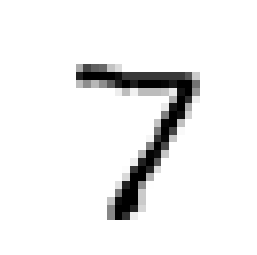

In [9]:
digit_image = first_image.reshape(28, 28)
plt.imshow(digit_image, cmap = matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

Sure enough, the label for the first image is 7, as expected.

## Fitting a deep feedforward neural network using tf.learn

Tensorflow includes a DNNClassifier estimator class, which allows us to `fit()` and `predict()` a classifier model, just like we saw in Lab 06.

When we create the DNNClassifier object, we specify the number of units in the hidden layers, and also the number of output classes. We use a softmax activation function for the output layer (commonly used in neural network approaches with classifier tasks). The softmax function transforms the outputs so that the outputs can be interpreted as the probability of each of the 10 classes. (In particular, each output is in the range [0,1] and the sum over all outputs is 1.00; see the Hands-On book chapter 4 for details).

Softmax function:

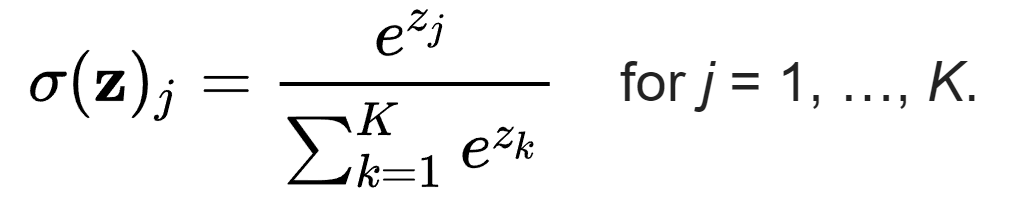


In [10]:
import tensorflow as tf

config = tf.contrib.learn.RunConfig(tf_random_seed=42) # for reproducability

feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                         feature_columns=feature_cols, config=config)
dnn_clf = tf.contrib.learn.SKCompat(dnn_clf) # if TensorFlow >= 1.1
dnn_clf.fit(X_train, y_train, batch_size=50, steps=40000)

Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
Instructions for updating:
Please specify feature columns explicitly.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please access pandas data directly.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please convert numpy dtypes explicitly.
Instructions for updating:
Please specify feature columns explicitly.
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_train_distribute': None, '_save_checkpoints_secs': 600, '_num_worker_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_task_type': None, '_evaluation_master': '', '_log_step_count_steps': 100, '_cluster_s

INFO:tensorflow:global_step/sec: 416.066
INFO:tensorflow:loss = 0.052520014, step = 3101 (0.240 sec)
INFO:tensorflow:global_step/sec: 437.862
INFO:tensorflow:loss = 0.009209794, step = 3201 (0.228 sec)
INFO:tensorflow:global_step/sec: 392.629
INFO:tensorflow:loss = 0.03838505, step = 3301 (0.255 sec)
INFO:tensorflow:global_step/sec: 419.194
INFO:tensorflow:loss = 0.24905375, step = 3401 (0.238 sec)
INFO:tensorflow:global_step/sec: 412.44
INFO:tensorflow:loss = 0.11074839, step = 3501 (0.243 sec)
INFO:tensorflow:global_step/sec: 413.915
INFO:tensorflow:loss = 0.19260898, step = 3601 (0.242 sec)
INFO:tensorflow:global_step/sec: 400.126
INFO:tensorflow:loss = 0.031413205, step = 3701 (0.250 sec)
INFO:tensorflow:global_step/sec: 396.251
INFO:tensorflow:loss = 0.010932315, step = 3801 (0.252 sec)
INFO:tensorflow:global_step/sec: 396.47
INFO:tensorflow:loss = 0.05704155, step = 3901 (0.253 sec)
INFO:tensorflow:global_step/sec: 407.414
INFO:tensorflow:loss = 0.11138899, step = 4001 (0.245 sec

INFO:tensorflow:loss = 0.0009773421, step = 11201 (0.258 sec)
INFO:tensorflow:global_step/sec: 407.803
INFO:tensorflow:loss = 0.0070549427, step = 11301 (0.245 sec)
INFO:tensorflow:global_step/sec: 391.497
INFO:tensorflow:loss = 0.005630137, step = 11401 (0.256 sec)
INFO:tensorflow:global_step/sec: 442.153
INFO:tensorflow:loss = 0.0145916855, step = 11501 (0.226 sec)
INFO:tensorflow:global_step/sec: 399.776
INFO:tensorflow:loss = 0.0012559271, step = 11601 (0.250 sec)
INFO:tensorflow:global_step/sec: 430.415
INFO:tensorflow:loss = 0.003457936, step = 11701 (0.232 sec)
INFO:tensorflow:global_step/sec: 196.468
INFO:tensorflow:loss = 0.0006845708, step = 11801 (0.515 sec)
INFO:tensorflow:global_step/sec: 381.79
INFO:tensorflow:loss = 0.0059772716, step = 11901 (0.256 sec)
INFO:tensorflow:global_step/sec: 319.373
INFO:tensorflow:loss = 0.00036859617, step = 12001 (0.313 sec)
INFO:tensorflow:global_step/sec: 415.934
INFO:tensorflow:loss = 0.0024173704, step = 12101 (0.240 sec)
INFO:tensorfl

INFO:tensorflow:loss = 0.0010995147, step = 19201 (0.559 sec)
INFO:tensorflow:global_step/sec: 172.241
INFO:tensorflow:loss = 0.0060072844, step = 19301 (0.584 sec)
INFO:tensorflow:global_step/sec: 179.692
INFO:tensorflow:loss = 0.0016744531, step = 19401 (0.551 sec)
INFO:tensorflow:global_step/sec: 168.426
INFO:tensorflow:loss = 0.0018779376, step = 19501 (0.598 sec)
INFO:tensorflow:global_step/sec: 169.456
INFO:tensorflow:loss = 0.0010008914, step = 19601 (0.586 sec)
INFO:tensorflow:global_step/sec: 147.278
INFO:tensorflow:loss = 0.00011776246, step = 19701 (0.683 sec)
INFO:tensorflow:global_step/sec: 140.503
INFO:tensorflow:loss = 0.00051290746, step = 19801 (0.710 sec)
INFO:tensorflow:global_step/sec: 134.176
INFO:tensorflow:loss = 0.0026860654, step = 19901 (0.750 sec)
INFO:tensorflow:global_step/sec: 161.631
INFO:tensorflow:loss = 0.0021910947, step = 20001 (0.622 sec)
INFO:tensorflow:global_step/sec: 152.118
INFO:tensorflow:loss = 0.00056302146, step = 20101 (0.647 sec)
INFO:ten

INFO:tensorflow:global_step/sec: 154.799
INFO:tensorflow:loss = 0.00046981542, step = 27201 (0.647 sec)
INFO:tensorflow:global_step/sec: 149.695
INFO:tensorflow:loss = 0.0011092882, step = 27301 (0.674 sec)
INFO:tensorflow:global_step/sec: 150.971
INFO:tensorflow:loss = 0.00048350834, step = 27401 (0.657 sec)
INFO:tensorflow:global_step/sec: 156.795
INFO:tensorflow:loss = 0.0009917895, step = 27501 (0.635 sec)
INFO:tensorflow:global_step/sec: 157.454
INFO:tensorflow:loss = 0.0012586172, step = 27601 (0.635 sec)
INFO:tensorflow:global_step/sec: 138.528
INFO:tensorflow:loss = 0.0002385981, step = 27701 (0.723 sec)
INFO:tensorflow:global_step/sec: 155.086
INFO:tensorflow:loss = 0.00019820215, step = 27801 (0.645 sec)
INFO:tensorflow:global_step/sec: 153.891
INFO:tensorflow:loss = 0.0005064024, step = 27901 (0.649 sec)
INFO:tensorflow:global_step/sec: 156.377
INFO:tensorflow:loss = 0.0012759421, step = 28001 (0.639 sec)
INFO:tensorflow:global_step/sec: 171.733
INFO:tensorflow:loss = 0.0006

INFO:tensorflow:loss = 0.00081289676, step = 35101 (0.273 sec)
INFO:tensorflow:global_step/sec: 413.531
INFO:tensorflow:loss = 0.00025221487, step = 35201 (0.242 sec)
INFO:tensorflow:global_step/sec: 392.377
INFO:tensorflow:loss = 0.00012703237, step = 35301 (0.255 sec)
INFO:tensorflow:global_step/sec: 371.094
INFO:tensorflow:loss = 0.0012054082, step = 35401 (0.269 sec)
INFO:tensorflow:global_step/sec: 360.952
INFO:tensorflow:loss = 0.00028712171, step = 35501 (0.279 sec)
INFO:tensorflow:global_step/sec: 315.522
INFO:tensorflow:loss = 0.00030749448, step = 35601 (0.315 sec)
INFO:tensorflow:global_step/sec: 352.736
INFO:tensorflow:loss = 0.00078599376, step = 35701 (0.284 sec)
INFO:tensorflow:global_step/sec: 339.767
INFO:tensorflow:loss = 0.0006209905, step = 35801 (0.295 sec)
INFO:tensorflow:global_step/sec: 334.641
INFO:tensorflow:loss = 0.00037393943, step = 35901 (0.298 sec)
INFO:tensorflow:global_step/sec: 346.666
INFO:tensorflow:loss = 0.00032404833, step = 36001 (0.289 sec)
INF

SKCompat()

Now that we have fitted our neural network classifier, let's make predictions for the test set and evaluate accuracy: 

In [11]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test)
accuracy_score(y_test, y_pred['classes'])

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpkk39ev4s/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


0.9836

When a network's output vector is interpreted as a probability distribution over classes (as is the case here) then it is better to calculate the error signal (i.e. the mismatch between the model's output, yp, and the correct target output, yt) using cross entropy, rather than as the squared difference. 

cross entropy error = log loss = -log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))

We can see this error metric reported for each training epoch above.

We can also calculate the cross entropy error over the test set:

In [12]:
from sklearn.metrics import log_loss

y_pred_proba = y_pred['probabilities']
log_loss(y_test, y_pred_proba)

0.07075033290710568

## Using plain TensorFlow

The above code makes use of the `DNNClassifier` object from TensorFlow, which has a very convienient high-level API which is similar to SciKit-Learn's API.

However, in general you may wish to specify the computation graph yourself, to build bespoke solutions for a particular machine learning task.

Here, we implement the same network as above, but using "plain" tensorflow.

In [13]:
import tensorflow as tf

n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [14]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y") 

The `dense` function used below creates a suitably randomly initialised fully-connected set of weights between each layer. It also takes care of the bias input.

To keep everything organised, we can arrange nodes in the computation graph into different "name scopes" to group related nodes.

In [15]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs", activation=None) 
    # note no explicit softmax

In [16]:
with tf.name_scope("loss"):
    # sparse_softmax_cross_entropy_with_logits calculates the error 
    # *before* applying softmax to the outputs.
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [17]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss) # we minimise xentropy error

In [18]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [19]:
init = tf.global_variables_initializer()
#saver = tf.train.Saver()

In [20]:
n_epochs = 50
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

    #save_path = saver.save(sess, "./my_model_final.ckpt")

0 Train accuracy: 0.9 Test accuracy: 0.9053
1 Train accuracy: 0.94 Test accuracy: 0.9222
2 Train accuracy: 0.92 Test accuracy: 0.93
3 Train accuracy: 0.96 Test accuracy: 0.9373
4 Train accuracy: 0.94 Test accuracy: 0.9427
5 Train accuracy: 0.94 Test accuracy: 0.9473
6 Train accuracy: 0.98 Test accuracy: 0.95
7 Train accuracy: 0.96 Test accuracy: 0.9526
8 Train accuracy: 0.96 Test accuracy: 0.9575
9 Train accuracy: 0.94 Test accuracy: 0.9584
10 Train accuracy: 0.98 Test accuracy: 0.9624
11 Train accuracy: 0.94 Test accuracy: 0.9636
12 Train accuracy: 0.98 Test accuracy: 0.966
13 Train accuracy: 0.92 Test accuracy: 0.9651
14 Train accuracy: 1.0 Test accuracy: 0.968
15 Train accuracy: 1.0 Test accuracy: 0.969
16 Train accuracy: 0.98 Test accuracy: 0.9696
17 Train accuracy: 0.96 Test accuracy: 0.9686
18 Train accuracy: 1.0 Test accuracy: 0.9715
19 Train accuracy: 1.0 Test accuracy: 0.9714
20 Train accuracy: 1.0 Test accuracy: 0.9722
21 Train accuracy: 1.0 Test accuracy: 0.9717
22 Train acc